Author(s): Piyush Amitabh

Details: this code generates mip and stitches them to visualize the img stacks

Created: May 02, 2023

License: GNU GPL v3.0

Comment: it is scope agnostic (KLA/WIL LSM) and os agnostic

Updated: 29 Sep, 23

Detail: now this works with multi folder/multi acquisition

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
import skimage
from PIL import Image
import tifffile as tiff
from natsort import natsorted

In [44]:
from tqdm import tqdm
import configparser
import re

In [45]:
# top_dir = os.path.normpath(input('Enter the top directory with ALL acquisitions: '))
# action_flag = int(input('''Do you want to:
#                     1. Find Max Intensity Projection AND Stitch (default)
#                     2. Only find Max Intensity Projection
#                     3. Only Stitch''') or '1')

In [46]:
#testing
top_dir = '/media/chiron/WD Elements/phox2bb_mpeg_z20_time lapse_downsampled/fish1/BF/'
action_flag = 3

# Batchprocess MIP

In [47]:
def batchprocess_mip(main_dir):
    print('Warning: This code ONLY works with single channel z-stack tiff images. It will give unpredictable results with >3 dimensions')
    channel_names = ['GFP', 'RFP']
    for root, subfolders, filenames in os.walk(main_dir):
        for filename in filenames:
            # print(f'Reading: {filename}')
            filepath = os.path.join(root, filename)
            # print(f'Reading: {filepath}')
            filename_list = filename.split('.')
            og_name = filename_list[0] #first of list=name
            ext = filename_list[-1] #last of list=extension

            if ext=="tif" or ext=="tiff": #tiff files
                read_image = tiff.imread(filepath)

                if len(read_image.shape)==3: #check if 3D images
                    print(f'Processing MIP for: {filepath}')
                    arr_mip = np.max(read_image, axis=0) #create MIP

                    for ch_name in channel_names: #save mip array in right directory with correct channel name
                        if ch_name.casefold() in og_name.casefold():
                            dest = os.path.join(root, ch_name.casefold()+'_mip')
                            if not os.path.exists(dest): #check if the dest exists
                                print("Write path doesn't exist.")
                                os.makedirs(dest)
                                print(f"Directory '{ch_name.casefold()}_mip' created")

                            img_mip = skimage.util.img_as_uint(skimage.exposure.rescale_intensity(arr_mip))
                            if og_name.endswith('_MMStack_1'): #skip file
                                continue
                            elif og_name.endswith('_MMStack'): #remove 'MMStack' in saved name
                                save_name = og_name[:-len('_MMStack')]+'_mip.'+ext
                            else:
                                save_name = og_name+'_mip.'+ext
                            tiff.imwrite(os.path.join(dest, save_name), img_mip)

In [48]:
if action_flag!=3:
    batchprocess_mip(main_dir=top_dir)

# Stitching

In [49]:
if action_flag==2: #don't stitch and exit
    exit()

In [50]:
print("Instructions for stitching:")
print("Image stitching works by reading stage positions from the 'notes.txt' file generated during acquisition")
print("-Images MUST have 'timepoint' substring in their names")
print("-Images MUST have 'pos' or 'region' substring in their names")
print("-Images MUST have channel substring(BF/GFP/RFP) in their names")

# stitch_dir_flag = input("Is stitching directory same as Parent directory above?(y/n-default): ") or 'n'
# if stitch_dir_flag.casefold()=='y':
#     stitch_dir = main_dir
# else:
#     stitch_dir = input('Enter the location of Parent directory for stitching (must contain MIPs and notes.txt file inside): ')

Instructions for stitching:
Image stitching works by reading stage positions from the 'notes.txt' file generated during acquisition
-Images MUST have 'timepoint' substring in their names
-Images MUST have 'pos' or 'region' substring in their names
-Images MUST have channel substring(BF/GFP/RFP) in their names


In [51]:
# # all unique BF location gets added to the main_dir_list
# main_dir_list = []
# for root, subfolders, _ in os.walk(top_dir):
#     if "BF" in subfolders:
#         main_dir_list.append(root)
# print(f'Found these fish data:\n{main_dir_list}')

#testing
main_dir_list = [top_dir]
print(f'Found these fish data:\n{main_dir_list}')

Found these fish data:
['/media/chiron/WD Elements/phox2bb_mpeg_z20_time lapse_downsampled/fish1/BF/']


In [52]:
pos_input_flag = input('Is the number of pos/regions in each folder above the same? (y-default/n)') or 'y'
if pos_input_flag.casefold()=='y':
    pos_max_list = len(main_dir_list)* \
    [int(input('Enter number of positions/regions of imaging per timepoint (default=4)') or '4')]
else:
    pos_max_list = []
    while pos_max_list != len(main_dir_list):
        pos_max_list = (input('Enter the list of positions/regions separated by space in the above order')).split()
        if pos_max_list != len(main_dir_list):
            print('entered list length is not same as the number of folders found above. Please re-enter.')
            continue
        else:
            # convert each item to int type
            for i in range(len(pos_max_list)):
                pos_max_list[i] = int(pos_max_list[i])

In [53]:
pos_max_list

[4]

In [54]:
findscope_flag = 0 #this is a global var

def find_lsm_scope(img_h, img_w):
    '''Finds LSM Scope and downscaling factor automatically using image height and width.
    Returns: 
    ds_factor_h = downscaling factor in height, 
    ds_factor_w = downscaling factor in width'''

    global findscope_flag #refer to the global var

    if img_w==img_h: # probably KLA LSM
        findscope_flag = 1

        ds_factor_h = 2048//img_h
        ds_factor_w = 2048//img_w
        r = 2048%img_h

        if r>0: #implying downscaling factor is in fraction
            findscope_flag = 0
            print("Downscaling factor in fraction. Can't process automatically.")

    elif img_w>img_h: # probably WIL LSM
        findscope_flag = 2

        ds_factor_h = 2160//img_h
        ds_factor_w = 2560//img_w

        if ds_factor_h!=ds_factor_w:
            findscope_flag=0

        r_h = 2160%img_h
        r_w = 2560%img_w
        
        if r_h>0 or r_w>0 : #implying downscaling factor is in fraction
            findscope_flag = 0
            print("Downscaling factor in fraction. Can't process automatically.")

    if findscope_flag==1:
        print('LSM Scope used: KLA')
        print(f'Downscaling factor = {ds_factor_w}')
    elif findscope_flag==2:
        print('LSM Scope used: WIL')
        print(f'Downscaling factor = {ds_factor_w}')

    user_check = input('Is the above information correct?(y-default/n): ') or 'y'
    if user_check.casefold()=='n':
        findscope_flag = 0

    if findscope_flag==0: #couldn't find scope, enter manually
        print("ERROR: Failed to determine LSM scope automatically.\nEnter manually")
        findscope_flag = int(input('Enter the scope used:\n1 - KLA LSM Scope\n2 - WIL LSM Scope\nInput (1/2): '))
        if findscope_flag==1 or findscope_flag==2:
            ds_factor_h = int(input('Enter the downscaling factor in height: '))
            ds_factor_w = int(input('Enter the downscaling factor in width: '))
        else:
            print("Fatal Error: Exiting")
            exit()

    return(ds_factor_h, ds_factor_w)

In [55]:
# Helping functions
# removes dir and non-image(tiff) files from a list
def remove_non_image_files(big_list, root_path):
    small_list = []
    for val in big_list:
        if os.path.isfile(os.path.join(root_path, val)):  # file check
            filename_list = val.split(".")
            og_name = filename_list[0]
            ext = filename_list[-1]
            if ext == "tif" or ext == "tiff":  # img check
                small_list.append(val)
    return small_list


# correct the image list ordering
def reorder_files_by_pos_tp(file_list):
    ordered_file_list = []
    for tp in range(1, (len(file_list) // pos_max) + 1):
        for pos in range(1, pos_max + 1):
            for file_name in file_list:  # find the location in img_list with pos and tp
                if (f"pos{pos}_" in file_name.casefold()) and (
                    f"timepoint{tp}_" in file_name.casefold()
                ):
                    ordered_file_list.append(file_name)
    return ordered_file_list


# finds the target file nearest to the start_path
def find_nearest_target_file(target, start_path):
    """finds nearest target file to the 'start_path' in the dir structure
    returns the location of the found file"""
    while True:
        if os.path.isfile(os.path.join(start_path, target)):
            # found
            print(f"found {target} at:" + start_path)
            found_path = os.path.join(start_path, target)
            break

        if os.path.dirname(start_path) == start_path:  # reached root
            # not found
            print(f"Error: Can't find {target}, Enter manually")
            found_path = input("Enter complete path (should end with .txt): ")
            break
        start_path = os.path.dirname(start_path)
    return found_path

In [56]:
np.shape(img_list_per_tp)

(4, 540, 640)

In [57]:
poses = np.shape(img_list_per_tp)[0]
img_height = np.shape(img_list_per_tp)[1]
img_width = np.shape(img_list_per_tp)[2]

In [58]:
stage_coords

array([[-2088., -4208.,  7907.],
       [-2111., -3808.,  8029.],
       [-2206., -3408.,  8053.],
       [-2283., -3008.,  8093.]])

In [59]:
stage_origin = stage_coords[0].copy()
global_coords_um = stage_coords - stage_origin
# global_coords_um[:, [1, 0]] = global_coords_um[:, [0, 1]]  # swap x and y axis = 1st and 2nd columns
global_coords_um[:, 0] = global_coords_um[:, 0] * -1  # flip x axis
global_coords_um


array([[  -0.,    0.,    0.],
       [  23.,  400.,  122.],
       [ 118.,  800.,  146.],
       [ 195., 1200.,  186.]])

In [60]:

# find height and width offsets
global_coords_px_width_offset1 = (np.ceil(global_coords_um[:, 0] / new_spacing[1])).astype(int)  # has first img as origin - xoffset
global_coords_px_width_offset2 = (np.ceil(global_coords_um[:, 1] / new_spacing[2])).astype(int)
global_coords_px_width_offset = np.vstack((global_coords_px_width_offset1, global_coords_px_width_offset2)).T
global_coords_px_width_offset

array([[   0,    0],
       [  36,  616],
       [ 182, 1231],
       [ 300, 1847]])

In [61]:
# stitching along img_width, so choose img with minimum x-dv as the new origin
height_offset_origin = np.argmin(global_coords_px_width_offset, axis=0)[0]  # axis-0 is columnwise
height_offset_origin

0

In [62]:
global_coords_px_height_offset = global_coords_px_width_offset - global_coords_px_width_offset[height_offset_origin]
global_coords_px_height_offset

array([[   0,    0],
       [  36,  616],
       [ 182, 1231],
       [ 300, 1847]])

In [68]:
width_max = abs(np.amax(global_coords_px_width_offset, axis=0)[1]) + img_width
height_max = abs(np.amax(global_coords_px_height_offset, axis=0)[0]) + img_height
stitched_image = np.zeros([height_max, width_max]) #rows-height, cols-width
for i in range(poses):
    print(i)
    h0 = global_coords_px_height_offset[i, 0]  # ith row and 1st column in global coords
    w0 = global_coords_px_width_offset[i, 1]
    stitched_image[h0 : h0 + img_height, w0 : w0 + img_width] = img_list_per_tp[i]

0
1
2
3


/home/chiron/miniconda3/envs/image_analysis/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


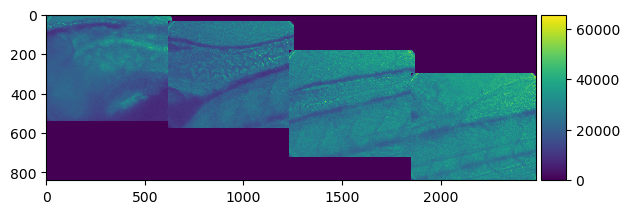

In [71]:
skimage.io.imshow(stitched_image)

In [67]:
width_max

940

In [29]:
def wil_stitch(stage_coords, img_list):
    stage_origin = stage_coords[0].copy()
    global_coords_um = stage_coords - stage_origin
    global_coords_um[:, [1, 0]] = global_coords_um[:, [0, 1]]  # swap x and y axis = 1st and 2nd columns

    poses = np.shape(img_list)[0]
    img_height = np.shape(img_list)[1]
    img_width = np.shape(img_list)[2]
    # we only care about x and y, so get rid of last column
    # um to pixels: 1px = (1/pixel width) um
    # global_coords_px_xoffset = (np.ceil(global_coords_um[:, :-1] / 0.65)).astype(int) #has first img as origin

    # find horizontal (h) and vertical (v) offsets
    global_coords_px_hoffset1 = (np.ceil(global_coords_um[:, 0] / new_spacing[1])).astype(int)  # has first img as origin - xoffset
    global_coords_px_hoffset2 = (np.ceil(global_coords_um[:, 1] / new_spacing[2])).astype(int)
    global_coords_px_hoffset = np.vstack((global_coords_px_hoffset1, global_coords_px_hoffset2)).T

    # stitching along x, so choose img with minimum y as the new origin
    v_offset_origin = np.argmin(global_coords_px_hoffset, axis=0)[1]  # axis-0 is columnwise
    global_coords_px_voffset = (
        global_coords_px_hoffset - global_coords_px_hoffset[v_offset_origin]
    )  # change origin to min y img

    # y is height of the image which means it is the rows in the image
    # x is the first row in the image, y is the 2nd row
    x_max = (
        abs(np.amax(global_coords_px_hoffset, axis=0)[0]) + img_width
    )  # zeroth element of last list
    y_max = (
        abs(np.amax(global_coords_px_voffset, axis=0)[1]) + img_height
    )  # 2nd element of last list=last image y-coord
    stitched_image = np.zeros([y_max, x_max])
    for i in range(poses):
        x0 = global_coords_px_hoffset[
            i, 0
        ]  # ith row and 1st column in global coords
        y0 = global_coords_px_voffset[i, 1]
        stitched_image[y0 : y0 + img_height, x0 : x0 + img_width] = img_list[i]
    return stitched_image

In [30]:

def img_stitcher(stage_coords, img_list):
    """accept a list of 2D images in img_list and use stage_coords read from notes.txt to stitch images
    Returns: 2D np.array containing the stitched image
    """
    stitched_image = None
    if findscope_flag == 0:
        print("ERROR: Couldn't find the LSM scope")
        exit()
    elif findscope_flag == 1:  # call kla_stitch
        stitched_image = kla_stitch(stage_coords, img_list)
    elif findscope_flag == 2:  # call wil stitch
        stitched_image = wil_stitch(stage_coords, img_list)
    return stitched_image

def kla_stitch(stage_coords, img_list):
    stage_origin = stage_coords[0].copy()
    global_coords_um = stage_coords - stage_origin
    global_coords_um[:, 0] = global_coords_um[:, 0] * -1  # flip x axis

    poses = np.shape(img_list)[0]
    img_height = np.shape(img_list)[1]
    img_width = np.shape(img_list)[2]

    # we only care about x and y, so get rid of last column
    # um to pixels: 1px <-> 0.65um use downscaling factor
    # global_coords_px_yoffset = (np.ceil(global_coords_um[:, :-1] / 0.65)).astype(int) #has first img as origin - yoffset

    global_coords_px_yoffset1 = (
        np.ceil(global_coords_um[:, 0] / new_spacing[1])
    ).astype(
        int
    )  # has first img as origin - yoffset
    global_coords_px_yoffset2 = (
        np.ceil(global_coords_um[:, 1] / new_spacing[2])
    ).astype(int)
    global_coords_px_yoffset = np.vstack(
        (global_coords_px_yoffset1, global_coords_px_yoffset2)
    ).T

    # stitching along y, so choose img with minimum x to find x-offset
    x_offset_origin = np.argmin(global_coords_px_yoffset, axis=0)[
        0
    ]  # axis-0 is columnwise
    global_coords_px_xoffset = (
        global_coords_px_yoffset - global_coords_px_yoffset[x_offset_origin]
    )  # change origin to min x img

    # y is height of the image which means it is the rows in the image
    # x is the first row in the image, y is the 2nd row
    x_max = (
        abs(np.amax(global_coords_px_xoffset, axis=0)[0]) + img_width
    )  # zeroth element of last list
    y_max = (
        abs(np.amax(global_coords_px_yoffset, axis=0)[1]) + img_height
    )  # 2nd element of last list=last image y-coord
    stitched_image = np.zeros([y_max, x_max])
    for i in range(poses):
        x0 = global_coords_px_xoffset[
            i, 0
        ]  # ith row and 1st column in global coords
        y0 = global_coords_px_yoffset[i, 1]
        stitched_image[y0 : y0 + img_height, x0 : x0 + img_width] = img_list[i]
    return stitched_image

In [31]:
sub_names = ["BF", "GFP", "RFP"]
target1 = "notes.txt"
target2 = "Notes.txt"

for main_dir, pos_max in zip(main_dir_list, pos_max_list):  # main_dir = location of Directory containing ONE fish data \n(this must contain BF/MIPs):
    # make a list of all 2D img files by channel
    bf_flag, gfp_flag, rfp_flag = False, False, False  # 0 means not found, 1 mean found
    bf_path, gfp_mip_path, rfp_mip_path = "", "", ""
    bf_img_list, gfp_img_list, rfp_img_list = [], [], []

    for root, subfolders, filenames in os.walk(main_dir):
        for filename in filenames:
            filepath = os.path.join(root, filename)
            # print(f'Reading: {filepath}')
            filename_list = filename.split(".")
            og_name = filename_list[0]  # first of list=name
            ext = filename_list[-1]  # last of list=extension

            if ext == "tif" or ext == "tiff":
                if (not bf_flag) and ("bf" in og_name.casefold()):  # find BF
                    print("BF images found at:" + root)
                    bf_path = root
                    bf_img_list = reorder_files_by_pos_tp(
                        remove_non_image_files(natsorted(os.listdir(root)), root)
                    )
                    bf_flag = True
                elif "mip" in og_name.casefold():
                    if (not gfp_flag) and ("gfp" in og_name.casefold()):
                        print("GFP MIP images found at:" + root)
                        gfp_mip_path = root
                        gfp_img_list = reorder_files_by_pos_tp(
                            remove_non_image_files(natsorted(os.listdir(root)), root)
                        )
                        gfp_flag = True
                    elif (not rfp_flag) and ("rfp" in og_name.casefold()):
                        print("RFP MIP images found at:" + root)
                        rfp_mip_path = root
                        rfp_img_list = reorder_files_by_pos_tp(
                            remove_non_image_files(natsorted(os.listdir(root)), root)
                        )
                        rfp_flag = True
    if not bf_flag:
        print(f"No BF images found in {main_dir}")
    if not gfp_flag:
        print(f"No GFP MIP images found in {main_dir}")
    if not rfp_flag:
        print(f"No RFP MIP images found in {main_dir}")

    # Stitch images

    # find the nearest notes.txt
    config = configparser.ConfigParser()
    start_path = ""
    img = np.zeros((1, 1))  # dummy
    # get start_path for search
    # get sample image to find scope and downscaling factor
    if gfp_flag:
        start_path = gfp_mip_path
        img = tiff.imread(os.path.join(gfp_mip_path, gfp_img_list[0]))
    elif rfp_flag:
        start_path = rfp_mip_path
        img = tiff.imread(os.path.join(rfp_mip_path, rfp_img_list[0]))
    elif bf_flag:
        start_path = bf_path
        img = tiff.imread(os.path.join(bf_path, bf_img_list[0]))
    # find the fish number from the image path
    fish_num = int(
        start_path[start_path.casefold().rfind("fish") + len("fish")]
    )  # find fish number starting from the child dir
    print(f"Found fish_num = {fish_num}")
    # user_check = "y"
    # if user_check.casefold() == "n":
    #     fish_num = int(input("Enter fish_num: "))

    while True:
        if os.path.isfile(os.path.join(start_path, target1)):
            # found
            print(f"found {target1} at:" + start_path)
            config.read(os.path.join(start_path, target1))
            break
        elif os.path.isfile(os.path.join(start_path, target2)):
            # found
            print(f"found {target2} at:" + start_path)
            config.read(os.path.join(start_path, target2))
            break

        if os.path.dirname(start_path) == start_path:  # reached root
            # not found
            print("Error: Can't find notes.txt, Enter manually")
            notes_path = input("Enter complete path (should end with .txt): ")
            config.read(notes_path)
            break
        start_path = os.path.dirname(start_path)
    # print(config.sections())
    abbrev = config.getfloat(f"Fish {fish_num} Region 1", "x_pos", fallback=False)
    if abbrev:
        # print('abbreviated')
        config_prop_list = ["x_pos", "y_pos", "z_pos"]
    else:
        # print('not abbreviated')
        config_prop_list = ["x_position", "y_position", "z_position"]
    stage_coords = np.zeros(shape=(pos_max, 3))
    for i in range(1, pos_max + 1):
        for j, val in enumerate(config_prop_list):  # x/y/z axes
            stage_coords[i - 1][j] = config.getfloat(f"Fish {fish_num} Region {i}", val)
    print(f"Found stage_coords: \n{stage_coords}")

    (ds_h, ds_w) = find_lsm_scope(img.shape[0], img.shape[1])

    # The pixel spacing in our LSM image is 1µm in the z axis, and  0.1625µm in the x and y axes.
    zd, xd, yd = 1, 0.1625, 0.1625  # zeroth dimension is z in skimage coords
    orig_spacing = np.array([zd, xd, yd])  # change to the actual pixel spacing from the microscope
    new_spacing = np.array([zd, xd * ds_w, yd * ds_h])  # multiply by the found downsampling factor

    # read all images per timepoint then stitch and save them at dest
    ch_flag_list = [bf_flag, gfp_flag, rfp_flag]
    ch_path_list = [bf_path, gfp_mip_path, rfp_mip_path]
    ch_img_list = [bf_img_list, gfp_img_list, rfp_img_list]

    for k, ch_flag in enumerate(ch_flag_list):
        all_img_list = ch_img_list[k]
        ch_name = sub_names[k]

        if ch_flag:
            print(f"Stitching {ch_name} images...")
            save_path = os.path.join(
                ch_path_list[k], ch_name.casefold() + "mip_stitched"
            )
            if not os.path.exists(save_path):  # check if the dest exists
                print("Save path doesn't exist.")
                os.makedirs(save_path)
                print(f"Directory '{ch_name.casefold()}_mip_stitched' created")
            else:
                print("Save path exists")

            for i in tqdm(
                range(len(all_img_list) // pos_max)
            ):  # run once per timepoint
                # print(f"tp: {i+1}")
                img_list_per_tp = [0] * pos_max
                for j in range(0, pos_max):
                    loc = i * pos_max + j
                    # print(loc)
                    img_list_per_tp[j] = tiff.imread(
                        os.path.join(ch_path_list[k], all_img_list[loc])
                    )  # save all pos images in 3D array

                stitched_img = img_stitcher(stage_coords, img_list_per_tp)
                stitched_img_uint = skimage.util.img_as_uint(
                    skimage.exposure.rescale_intensity(stitched_img)
                )  # rescale float and change dtype to uint16
                skimage.io.imsave(
                    os.path.join(save_path, f"Timepoint{i+1}_{ch_name}_stitched.png"),
                    stitched_img_uint,
                    check_contrast=False,
                )  # save the image

BF images found at:/media/chiron/WD Elements/phox2bb_mpeg_z20_time lapse_downsampled/fish1/BF/
No GFP MIP images found in /media/chiron/WD Elements/phox2bb_mpeg_z20_time lapse_downsampled/fish1/BF/
No RFP MIP images found in /media/chiron/WD Elements/phox2bb_mpeg_z20_time lapse_downsampled/fish1/BF/
Found fish_num = 1
found notes.txt at:/media/chiron/WD Elements/phox2bb_mpeg_z20_time lapse_downsampled
Found stage_coords: 
[[-2088. -4208.  7907.]
 [-2111. -3808.  8029.]
 [-2206. -3408.  8053.]
 [-2283. -3008.  8093.]]
LSM Scope used: WIL
Downscaling factor = 4


Stitching BF images...
Save path doesn't exist.
Directory 'bf_mip_stitched' created


100%|██████████| 40/40 [00:09<00:00,  4.10it/s]
